<a href="https://colab.research.google.com/github/2020-nlp-c/nlp-deeplearning/blob/master/sojeong/Word2Vec_%EC%A1%B0%EC%86%8C%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Word2Vec - CBow

In [14]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### 원핫인코딩

In [15]:
doc = "you will never know until you try"

doc_tokens = doc.split(" ")
tokens = np.unique(doc_tokens)

def one_hot_encode(doc_tokens):
    # 고유 단어와 인덱스를 매칭시켜주는 사전 생성
    word2id_dic = defaultdict(lambda: len(word2id_dic))

    # {단어 : 인덱스} 사전 구축
    for word in doc_tokens:
        word2id_dic[word]

    n_unique_words = len(word2id_dic) # 고유한 단어의 갯수
    one_hot_vectors = np.zeros((len(doc_tokens), n_unique_words)) # 원핫-벡터를 만들기 위해 비어있는 벡터 생성

    for i, word in enumerate(doc_tokens):
        index = word2id_dic[word] # 해당 단어의 고유 인덱스
        one_hot_vectors[i, index] = 1 # 해당 단어의 고유 인덱스에만 1을 더해줌

    return one_hot_vectors

one_hot_vectors = one_hot_encode(doc_tokens)
one_hot_vectors

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

### 학습

In [16]:
num_epoch = 10000
Window = 2
H = 4
alpha = 0.03
loss_epoch = []

# Weight
W1 = np.random.rand(len(tokens), H)
W2 = np.random.rand(H, len(tokens))

# 소프트맥스 함수
def softmax(a) :
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a

    return y

for epoch in range(num_epoch):
    loss = []
    for i, word in enumerate(doc_tokens):
        input_vec = []
        for j in range(1, Window+1):
            if i-j >= 0:
                input_vec.append(one_hot_vectors[i-j])
            try : input_vec.append(one_hot_vectors[i+j])
            except : pass

        Hidden = []
        for j in range(len(input_vec)):
            Hidden.append(np.dot(input_vec[j], W1))
        Hidden = np.sum(Hidden, axis=0) / len(input_vec)

        Predict = softmax(np.dot(Hidden, W2))

        for a in one_hot_vectors:
            L = -np.dot(a, np.log(Predict).reshape(len(Predict), 1))
            loss.extend(L)

        for i in one_hot_vectors:
            gradient_W2 = np.dot(Hidden.reshape(len(Hidden), 1), (Predict-i).reshape(1, len(Predict)))
            gradient_W1 = np.dot(input_vec[j].reshape(len(input_vec[j]), 1), np.dot(W2, (Predict-i)).reshape(1, len(W2)))

        W2 -= alpha * gradient_W2
        W1 -= alpha * gradient_W1

    loss_epoch.append(np.sum(L))

### Loss 시각화

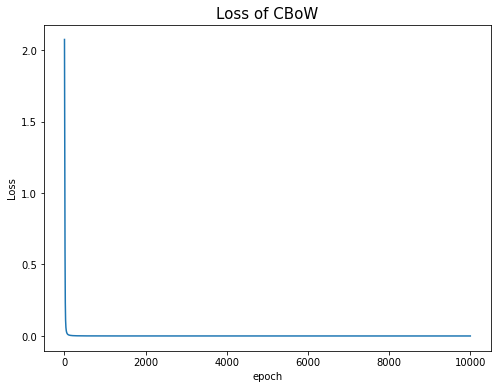

In [17]:
plt.plot(np.arange(num_epoch), loss_epoch)
plt.title("Loss of CBoW", size=15)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

### W1 벡터간 유사도 측정

In [22]:
pd.DataFrame(W1, index=tokens)

,0,1,2,3
know,1.278283,0.645312,1.465047,0.649609
never,0.496458,0.562817,0.391225,0.046761
try,2.412251,1.258120,1.564445,0.589443
until,1.429174,1.105640,1.108145,0.101146
will,1.928989,1.073007,1.980010,0.113780
you,1.161150,1.000643,1.272965,0.184532


In [27]:
simmilarity_minus = {} 
for i in range(len(tokens)):
    tmp = []
    for j in range(len(tokens)):
        simmilarity = np.dot(W1[i], W1[j]) / np.linalg.norm(W1[i]) * np.linalg.norm(W1[j])
        tmp.append(-simmilarity)
    simmilarity_minus[tokens[i]] = tmp

N_simmilar = 3
simmilarity_df = {}
for i, t in enumerate(tokens):
    tmp = np.argsort(simmilarity_minus[t])
    simmilarity_df[t] = tokens[np.delete(tmp, np.where(tmp == i))][:N_simmilar]

In [28]:
pd.DataFrame(simmilarity_df)

,know,never,try,until,will,you
0,try,try,will,try,try,try
1,will,will,know,will,know,will
2,until,until,until,know,until,until


In [18]:
def calc_similarity_matrix(vectors) :
  def cosine_similarity(a, b) : 
    return dot(a, b)/(norm(a)*norm(b))

  n_word = len(vectors)
  similarity_matrix = np.zeros((n_word, n_word))

  for i in range(n_word) :
    for j in range(i, n_word) :
      similarity_matrix[j, i] = cosine_similarity(vectors[i], vectors[j]).round(4)  

  return similarity_matrix

In [19]:
similarity_matrix = calc_similarity_matrix(W1)
similarity_matrix

array([[1.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.8791, 1.    , 0.    , 0.    , 0.    , 0.    ],
       [0.9574, 0.9404, 1.    , 0.    , 0.    , 0.    ],
       [0.9274, 0.9841, 0.9787, 1.    , 0.    , 0.    ],
       [0.9617, 0.9309, 0.9675, 0.9765, 1.    , 0.    ],
       [0.9568, 0.9706, 0.9641, 0.988 , 0.986 , 1.    ]])

In [20]:
def visualize_similarity(similarity_matrix) :
  uniform_data = similarity_matrix
  mask = np.triu(np.ones_like(similarity_matrix, dtype=np.bool))
  plt.rcParams['figure.figsize'] = [8, 6]
  ax = sns.heatmap(uniform_data, mask=mask, #xticklabels=features, yticklabels=features, 
                  annot=True, fmt=".2f",annot_kws={'size':8}, cmap='coolwarm')

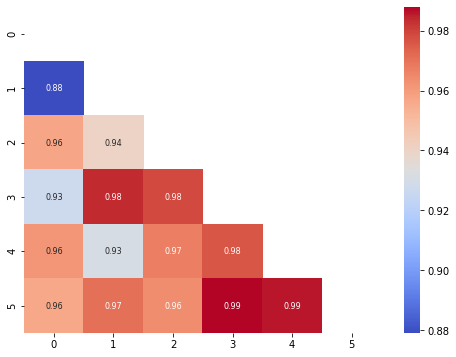

In [21]:
visualize_similarity(similarity_matrix)